In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
def dice_accuracy(y_true, y_pred, epsilon=1e-7):
  num_classes = y_true.shape[-1]
  y_true = tf.cast(y_true, tf.float32)
  y_pred_class = tf.one_hot(tf.argmax(y_pred, axis=-1), num_classes)
  y_true = y_true[..., 1:] # excluding background
  y_pred_class = y_pred_class[..., 1:] # excluding background
  intersection = tf.reduce_sum(y_true * y_pred_class, axis=[1, 2])
  union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred_class, axis=[1, 2])
  dice_scores = (2 * intersection + epsilon) / (union + epsilon)
  mean_dice = tf.reduce_mean(dice_scores)
  return mean_dice

In [ ]:
X_train = np.load('/content/drive/MyDrive/Veritas AI/Veritas AI - Micah/data/X_train.npy')
Y_train = np.load('/content/drive/MyDrive/Veritas AI/Veritas AI - Micah/data/Y_train.npy')
X_val = np.load('/content/drive/MyDrive/Veritas AI/Veritas AI - Micah/data/X_val.npy')
Y_val = np.load('/content/drive/MyDrive/Veritas AI/Veritas AI - Micah/data/Y_val.npy')

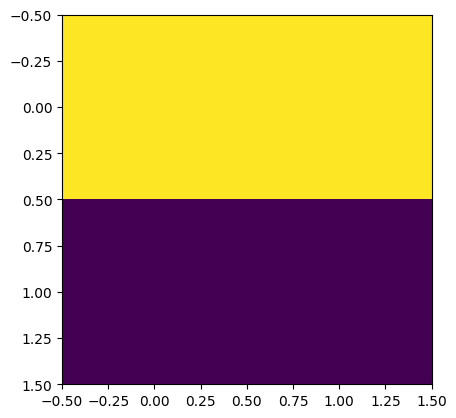

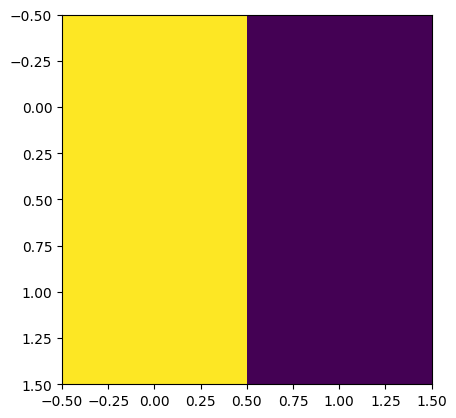

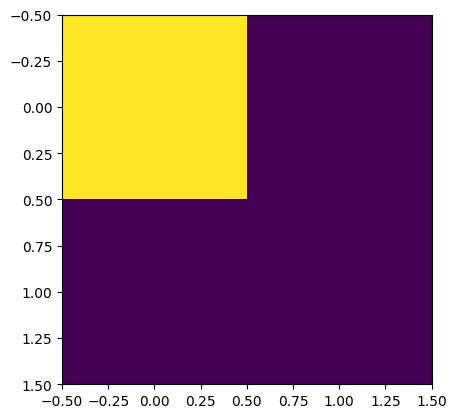

In [ ]:
A = np.array([[1, 1], [0,0]])
B = np.array([[1, 0], [1, 0]])
plt.figure()
plt.imshow(A)
plt.show()
plt.figure()
plt.imshow(B)
plt.show()
plt.figure()
plt.imshow(A*B)
plt.show()

In [ ]:
def get_DSC(A, B):
  DSC = (2*np.sum(A*B) + 1e-10) / (np.sum(A) + np.sum(B) + 1e-10)
  return DSC

In [ ]:
#unet_model = tf.keras.models.load_model("/content/drive/MyDrive/Veritas AI/Veritas AI - Micah/code/models/unet_10_22.h5")
unet_model = tf.keras.models.load_model("/content/drive/MyDrive/Veritas AI/Veritas AI - Micah/code/models/unet_06_05.h5", custom_objects = {'dice_accuracy': dice_accuracy})

In [ ]:
Y_pred = unet_model.predict(X_val)
Y_pred = np.argmax(Y_pred, axis = -1)

34/34 [==============================] - 18s 253ms/step


In [ ]:
print(Y_val.shape)

(1076, 128, 128)


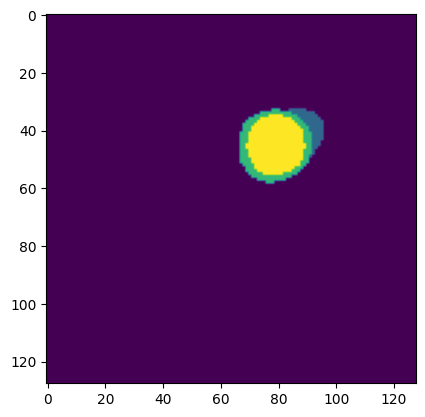

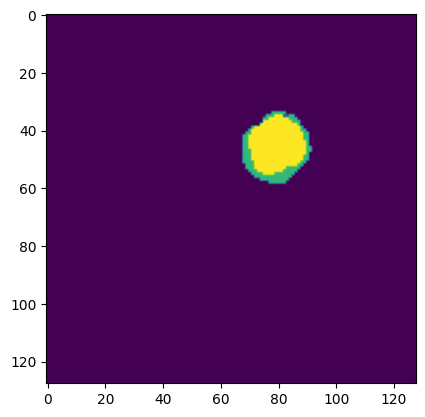

2.5442125237191067


In [ ]:
k = 200
mask_gt = Y_val[k, :, :]
mask_pred = Y_pred[k, :, :]
plt.figure()
plt.imshow(mask_gt)
plt.show()
plt.figure()
plt.imshow(mask_pred)
plt.show()
print(get_DSC(mask_gt, mask_pred))


In [ ]:
DSCs = np.zeros((Y_val.shape[0], 4))
for i in range(0, Y_val.shape[0]):
  for j in range(0, 4):
    mask_gt = Y_val[i, :, :] == j
    mask_pred = Y_pred[i, :, :] == j
    DSCs[i, j] = get_DSC(mask_gt, mask_pred)
# background, RV, myo, blood pool

In [ ]:
print(DSCs)
print(np.mean(DSCs[:, 1:]))
print(np.mean(DSCs[:, 1]), np.mean(DSCs[:, 2]), np.mean(DSCs[:, 3]))

[[9.97198356e-01 1.00000000e-10 5.31250000e-01 9.17960089e-01]
 [9.97129736e-01 9.16317992e-01 6.41114983e-01 9.48995363e-01]
 [9.97668998e-01 9.26530612e-01 7.50877193e-01 9.67455621e-01]
 ...
 [9.97943797e-01 7.09677419e-01 7.55244755e-01 8.37209302e-01]
 [9.97808304e-01 6.66666667e-01 7.54448399e-01 7.65957447e-01]
 [9.98043053e-01 1.00000000e+00 1.69491525e-12 2.00000000e-11]]
0.6868018890667553
0.6259398682865608 0.6478179824647113 0.786647816448994


In [ ]:
def get_list_of_patients_divided_by_time_frames(images_list):
  patients_list = []
  patient_list = []
  patient_ID = []
  patient_ED = []
  patient_ES = []
  patient_name = 'placeholder'
  for image_file in images_list:
    image_file_components = image_file.split('_')
    new_patient_name = image_file_components[0]
    time_frame = image_file_components[1]
    if new_patient_name != patient_name:
      patient_list = [patient_ID, patient_ED, patient_ES]
      patients_list.append(patient_list)
      patient_ID = new_patient_name
      patient_ED = []
      patient_ES = []
      patient_name = new_patient_name
    if time_frame == 'ED':
      patient_ED.append(image_file)
    if time_frame == 'ES':
      patient_ES.append(image_file)
  patients_list = patients_list[1:]
  return patients_list

In [ ]:
from skimage.transform import resize
from PIL import Image
def calculate_volumes(patients_list, trained_model):
  volumes_gt = np.zeros((len(patients_list), 3))
  volumes_pred = np.zeros((len(patients_list), 3))
  k = 0
  for patient_list in patients_list:
    for i in range(1, 3):
      volume_gt = 0
      volume_pred = 0
      for MRI_slice in patient_list[i]:
        image_path = os.path.join(val_images_path, MRI_slice)
        mask_path = os.path.join(val_masks_path, MRI_slice[0:-4] + '.png')
        image = np.array(Image.open(image_path).resize((input_shape[1], input_shape[0]))) / 255
        image = np.expand_dims(image, axis=(0, 3))
        mask_gt = np.array(Image.open(mask_path)) / 50
        mask_pred = trained_model.predict(image, verbose=0)
        mask_pred = np.argmax(mask_pred, axis=-1)
        mask_pred = mask_pred[0, :, :]
        mask_pred = resize(mask_pred, mask_gt.shape, order=0)
        area_gt = np.sum(mask_gt==3) * 1.5 * 1.5
        area_pred = np.sum(mask_pred==3) * 1.5 * 1.5
        volume_gt = volume_gt + (area_gt * 7.5) / 1000
        volume_pred = volume_pred + (area_pred * 7.5) / 1000
      volumes_gt[k, i-1] = volume_gt
      volumes_pred[k, i-1] = volume_pred
      volumes_gt[k, 1] = volume_gt
      volumes_gt[k, 2] = (volume_gt - volume_gt) / volume_gt * 100
    k = k + 1
  volumes_gt[:, 2] = (volumes_gt[:, 0] - volumes_gt[:, 1]) / volumes_gt[:, 0] * 100
  volumes_pred[:, 2] = (volumes_pred[:, 0] - volumes_pred[:, 1]) / volumes_pred[:, 0] * 100
  return volumes_gt, volumes_pred

In [ ]:
val_images_path = '/content/drive/MyDrive/Veritas AI/Veritas AI - Micah/data/ACDC/val/images'
val_masks_path = '/content/drive/MyDrive/Veritas AI/Veritas AI - Micah/data/ACDC/val/masks'
val_images_list = os.listdir(val_images_path)
val_images_list.sort()
input_shape = (128, 128, 1)

patients_list = get_list_of_patients_divided_by_time_frames(val_images_list)

advanced_volumes_gt, advanced_volumes_pred = calculate_volumes(patients_list, unet_model) # baseline_model

In [ ]:
import statsmodels.api as sm
from scipy.stats import linregress, pearsonr

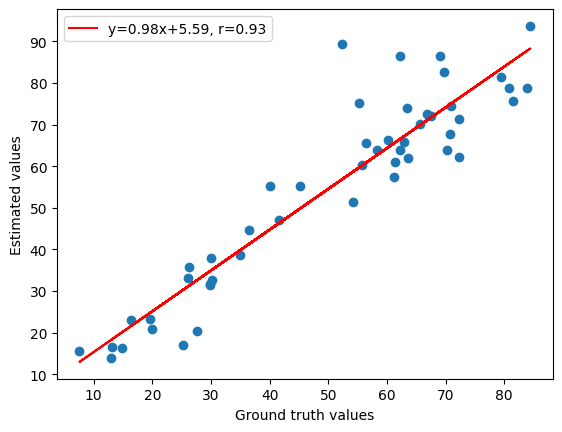

<Figure size 640x480 with 0 Axes>

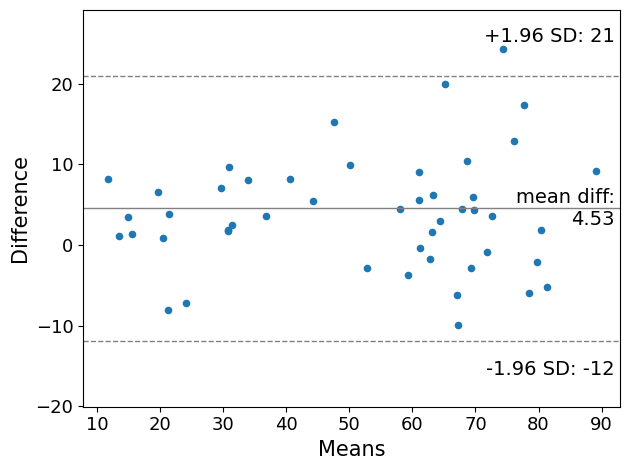

In [ ]:
manual_data = advanced_volumes_gt[:, 2]
auto_data = advanced_volumes_pred[:, 2]

slope, intercept, r_value, p_value, std_err = linregress(manual_data, auto_data)
line = slope * manual_data + intercept
r, p = pearsonr(manual_data, auto_data)

plt.figure()
plt.scatter(manual_data, auto_data)
plt.plot(manual_data, line, 'r', label='y={:.2f}x+{:.2f}, r={:.2f}'.format(slope, intercept, r))
plt.xlabel('Ground truth values')
plt.ylabel('Estimated values')
plt.legend(loc='best')
plt.show()

plt.figure()
sm.graphics.mean_diff_plot(auto_data, manual_data)
plt.show()

In [ ]:
print(np.mean(auto_data-manual_data))
print(np.std(auto_data-manual_data))
print(np.mean(auto_data-manual_data)+1.96*np.std(auto_data-manual_data))
print(np.mean(auto_data-manual_data)-1.96*np.std(auto_data-manual_data))

4.533202116005449
8.363563480641327
20.925786538062447
-11.85938230605155


DSC per class on baseline and advanced models
correlation plot and bland-altman plot on baseline and advanced models